# Imports

In [6]:
import os
import json
import random
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle

# Dataset Loader

In [21]:
# get path from config.json
with open('config.json') as f:
    config = json.load(f)

# Define paths to the image and annotation folders
train_img_folder = config['train']['train_img_folder']
train_ann_folder = config['train']['train_ann_folder']

In [8]:
class DatasetLoader:
    def __init__(self, img_folder, ann_folder, target_size=(224, 224)):
        self.img_folder = img_folder
        self.ann_folder = ann_folder
        self.target_size = target_size
        self.images = []
        self.annotations = []
    
    def load_dataset(self):
        # Iterate through each annotation file in the "ann" folder
        for ann_file in os.listdir(self.ann_folder):
            if ann_file.endswith('.json'):
                # Extract image filename from annotation filename
                img_filename = ann_file[:-5]  # Remove the last 5 characters (".json")

                # Load the corresponding image using PIL Image
                img_path = os.path.join(self.img_folder, img_filename)
                img = Image.open(img_path)
                
                # Load the annotation data from the JSON file
                with open(os.path.join(self.ann_folder, ann_file), 'r') as f: # r is for read
                    ann_data = json.load(f)
                
                # Extract bounding box coordinates and class labels
                boxes = []
                labels = []

                # for each object in the annotation file
                # extract the coordinates and classTitle
                for obj in ann_data['objects']:
                    xmin, ymin = obj['points']['exterior'][0] # bottom left corner
                    xmax, ymax = obj['points']['exterior'][1] # top right corner

                    # append the coordinates and classTitle to the boxes and labels lists
                    boxes.append([xmin, ymin, xmax, ymax]) 
                    labels.append(obj['classTitle'])
                
                # For every image, append image and annotations to the lists created in the __init__ method
                self.images.append(img) # in PIL Image format
                self.annotations.append({'boxes': boxes, 'labels': labels}) # in dictionary format

        # Display the number of images loaded
        print(f"Number of images loaded: {len(self.images)}")

    def resize_images(self):
        resized_images = []
        for img in self.images:
            resized_img = img.resize(self.target_size)
            resized_images.append(resized_img)
        self.images = resized_images

    def show_image_with_boxes(self, idx=None):

        if idx is None:
            # Select a random image from the dataset
            # get a random index from the images list
            idx = random.randint(0, len(self.images) - 1) 
        img = self.images[idx]
        annotations = self.annotations[idx]
        
        # Plot the image
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        # Get the current Axes instance on the current figure 
        # gca stands for get current axis
        ax = plt.gca()
        # ax is used to add patches to the image (e.g. bounding boxes, labels, etc.)
        
        # Plot bounding boxes

        # for each box and label in the annotations dictionary
        for box, label in zip(annotations['boxes'], annotations['labels']):
            # unpack the box coordinates
            xmin, ymin, xmax, ymax = box
            width = xmax - xmin
            height = ymax - ymin
            # create a Rectangle patch using matplotlib.patches
            rect = Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='b', facecolor='none')
            # add the rectangle to the Axes instance
            ax.add_patch(rect)
            # add a label to the rectangle
            plt.text(xmin, ymin, label, fontsize=10, color='r', verticalalignment='top', backgroundcolor='blue')
            #plt.text(xmin + 0.5 * width, ymin - 3, label, fontsize=10, color='r', ha='right', backgroundcolor='white')
        
        plt.axis('off')
        plt.show()

In [9]:
# train set loader
train_loader = DatasetLoader(train_img_folder, train_ann_folder)
train_loader.load_dataset()

Number of images loaded: 2246


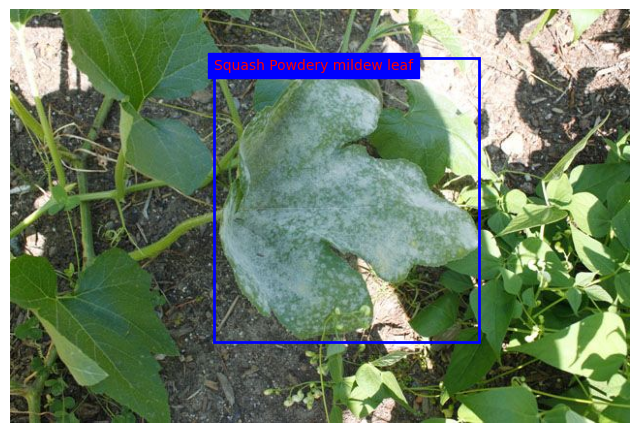

In [10]:
# show random image with bounding boxes
train_loader.show_image_with_boxes()

# Preprocessing

- Step 1: Resize Images

Resizing the images to a fixed size is essential because YOLOv5 requires a consistent input size for all images. Common input sizes for YOLOv5 are 416x416 or 608x608 pixels. Resizing ensures that the model receives inputs of uniform dimensions, which is necessary for efficient processing and training.
To resize the images, you can use the Python Imaging Library (PIL) or any other image processing library. 

- Step 2: Create Label Files

YOLOv5 requires label files for each image containing the ground truth bounding boxes and class labels. Each label file should have one row for each object in the image, with the format: class_index x_center y_center width height. The coordinates should be normalized to the range [0, 1] relative to the width and height of the image.

To create label files, you'll need to parse the annotations provided in your dataset and convert them into the required format. Since you already have annotations in the form of bounding boxes and class labels, you can iterate over each annotation, calculate the normalized coordinates, and write them to label files.

In [29]:
class Preprocess:
    def __init__(self, images, annotations):
        self.images = images
        self.annotations = annotations
        self.resized_images = []

    def resize_images(self, size=(416, 416)):
        """
        Resize all images in the dataset to the specified size.

        Args:
        - size: Tuple (width, height) representing the target size.

        Returns:
        - List of resized PIL.Image objects.
        """
        for img in self.images:
            resized_img = img.resize(size)
            self.resized_images.append(resized_img)
        print("UPDATE: resized all images successfully!")
        return self.resized_images
    
    def create_label_files(self, label_dir):
        """
        Create label files for each image in the dataset.

        Args:
        - output_dir: Directory to save the label files.

        Returns:
        - None
        """
        # resize images to 416x416 if not already done
        self.resize_images(size=(416, 416))
        print("UPDATE: Starting to create label files...")
        # iterate over each annotation and create a label file
        for idx, ann in enumerate(self.annotations):
            # Open a new label file for writing
            with open(os.path.join(label_dir, f'label_{idx}.txt'), 'w') as f:
                # Iterate over each bounding box and class label
                for box, label in zip(ann['boxes'], ann['labels']):
                    xmin, ymin, xmax, ymax = box
                    width = xmax - xmin
                    height = ymax - ymin
                    # Calculate normalized coordinates
                    x_center = (xmin + width / 2) / self.resized_images[idx].width
                    y_center = (ymin + height / 2) / self.resized_images[idx].height
                    normalized_width = width / self.resized_images[idx].width
                    normalized_height = height / self.resized_images[idx].height
                    # Write to label file
                    label_line = f"{label} {x_center} {y_center} {normalized_width} {normalized_height}\n"
                    f.write(label_line)
        print("UPDATE: created label files successfully!")

In [30]:
# get label directory from config.json
label_dir = config['output_dir']['label_files']
pp = Preprocess(train_loader.images, train_loader.annotations)

# create label files
pp.create_label_files(label_dir)

UPDATE: resized all images successfully!
UPDATE: Starting to create label files...
UPDATE: created label files successfully!
